In [734]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import glob
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import pdb
%matplotlib notebook
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [735]:
files = glob.glob('rollouts/*.npy')
rollouts = []
for file in files:
    rollout = np.load(file)
    rollouts.append(rollout)
rollouts = np.stack(rollouts)
cutoff = int(round(.7*len(rollouts)))
# for now, block out cube
# rollouts = rollouts[:,:,:3+12]
train_rollouts = rollouts[:cutoff]
val_rollouts = rollouts[cutoff:]
del rollouts

mean = train_rollouts.mean(axis=(0, 1))
std = train_rollouts.std(axis=(0, 1)) + .1

mean = torch.Tensor(mean).to(device)
std = torch.Tensor(std).to(device)

action_mean = mean[:3]
action_std = std[:3]
state_mean = mean[3:]
state_std = std[3:]
del mean
del std

KeyboardInterrupt: 

In [ ]:
class RolloutDataset(Dataset):
    def __init__(self, rollouts, indices):
        super().__init__()
        self.actions = rollouts[:, :, :3]
        self.states = rollouts[:, :, 3:]
        self.indices = indices
        n, t, _ = self.actions.shape
        self.n = n
        self.t = t
    
    def __getitem__(self, index):
        n = index // (self.t-1)
        t = index % (self.t-1)
        action_t = self.actions[n, t]
        state_t = self.states[n, t]
        state_t1 = self.states[n, t+1]
        delta = state_t1 - state_t
        return action_t, state_t, state_t1[self.indices]
        
    def __len__(self):
        return self.n * (self.t-1)

class FCNetwork(nn.Module):
    def __init__(self, action_size, state_size, output_size, hidden_layers = 3, hidden_size = 64, dropout = 0):
        super().__init__()
        self.action_linear = nn.Sequential(nn.Linear(action_size, hidden_size), nn.ReLU())
        self.action_hidden = nn.Sequential(*[nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden_size, hidden_size), nn.ReLU())])
        
        self.state_linear = nn.Sequential(nn.Linear(state_size, hidden_size), nn.ReLU())
        self.state_hidden = nn.Sequential(*[nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden_size, hidden_size), nn.ReLU())])
        
        self.hidden = nn.Sequential(*[nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden_size*2, hidden_size*2), nn.ReLU())])
        self.out = nn.Linear(hidden_size*2, output_size)
    
    def forward(self, a, s):
        a = self.action_linear(a)
        a = self.action_hidden(a)
        
        s = self.state_linear(s)
        s = self.state_hidden(s)
        
        x = torch.cat([a, s], dim=1)
        x = self.hidden(x)
        x = self.out(x)
        return x

In [ ]:
from matplotlib import pyplot as plt

indices = []
for i in range(117):
    indices.append(12*i+6)
    indices.append(12*i+7)
    indices.append(12*i+8)
    indices.append(12*i+11)

train_dataset = RolloutDataset(train_rollouts, indices = indices)
val_dataset = RolloutDataset(val_rollouts, indices = indices)
action_size = len(train_dataset[0][0])
state_size = len(train_dataset[0][1])
output_size = len(train_dataset[0][2])
dropout = .2
hidden_layers = 2
hidden_size = 1024

model = FCNetwork(3,
                  state_size,
                  output_size,
                  hidden_layers = hidden_layers,
                  hidden_size = hidden_size,
                  dropout = dropout)
model.to(device)

learning_rate = 3e-3
epochs = 5
batch_size = 128

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
loop = tqdm(total = len(train_dataloader) * epochs)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    for a, s, d in train_dataloader:
        s = s.float().to(device)
        s = (s - state_mean) / state_std
        
        a = a.float().to(device)
        a = (a - action_mean) / action_std
        
        d = d.float().to(device)
        d_hat = model(a, s)
        
        loss = (d - d_hat).pow(2).mean()
        if not val_losses:
            loop.set_description('loss: {:.3f}'.format(loss.item()))
        else:
            loop.set_description('loss: {:.4f}, val loss: {:.4f}'.format(loss.item(), val_losses[-1]))
        train_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.update(1)
    with torch.no_grad():
        model.eval()
        epoch_losses = []
        for a, s, d in train_dataloader:
            s = s.float().to(device)
            s = (s - state_mean) / state_std

            a = a.float().to(device)
            a = (a - action_mean) / action_std

            d = d.float().to(device)
            d_hat = model(a, s)

            loss = (d - d_hat).pow(2).mean()
            epoch_losses.append(loss.item())
        val_losses.append(np.mean(epoch_losses))
            
print(np.argmin(val_losses), np.min(val_losses))
skip = 200
plt.plot(train_losses[skip:])
plt.plot(len(train_dataloader)*np.arange(1, 1+epochs)-skip, val_losses)
plt.show()

In [737]:
def step(state, deltas):
    s = np.zeros(state.shape)
    # new position
    s[0::12] = state[0::12]  + deltas[0::4]
    s[1::12] = state[1::12]  + deltas[1::4]
    s[2::12] = state[2::12]  + deltas[2::4]
    # previous position
    s[3::12] = state[0::12]
    s[4::12] = state[1::12]
    s[5::12] = state[2::12]
    # delta
    s[6::12] = deltas[0::4]
    s[7::12] = deltas[1::4]
    s[8::12] = deltas[2::4]
    # rotation
    s[9::12] = state[9::12] + deltas[3::4]
    s[10::12] = state[9::12]
    s[11::12] = deltas[3::4]
    return s

def pred_rollout(rollout, model):
    actions = rollout[:, :3]
    states = rollout[:, 3:]
    # for saving all the predicted states
    states_pred = np.zeros(states.shape)
    # set first state to initial state
    states_pred[0] = states[0]
    for i in tqdm(range(0, len(states_pred)-1)):
        with torch.no_grad():
            a = torch.Tensor(actions[i]).unsqueeze(0).to(device)
            s = torch.Tensor(states_pred[i]).unsqueeze(0).to(device)
            a = (a - action_mean) / action_std
            s = (s - state_mean) / state_std
            deltas = model(a, s)
            deltas = deltas.squeeze(0).cpu().numpy()
            states_pred[i+1] = step(states_pred[i], deltas)
    return states_pred

# def step(previous, deltas):
#     s = np.zeros(previous.shape)
#     s[:3] = previous[:3] + deltas[:3]
#     s[3:6] = previous[:3]
#     s[6:9] = deltas[:3]
#     s[9] = previous[9] + deltas[3]
#     s[10] = previous[9]
#     s[11] = deltas[3]
#     return s
# 
# def pred_rollout(rollout, model):
#     actions = rollout[:, :3]
#     states = rollout[:, 3:]
#     states_pred = np.zeros(states.shape)
#     states_pred[0] = states[0]
#     for i in tqdm(range(0, len(states_pred)-1)):
#         with torch.no_grad():
#             x = np.hstack([actions[i], states_pred[i]])
#             x = torch.Tensor(x).unsqueeze(0).to(device)
#             x = (x - mean) / std
#             deltas = model(x)
#             deltas = deltas.squeeze(0).cpu().numpy()
#             states_pred[i+1] = step(states_pred[i], deltas)
#     return states_pred

In [738]:
# plt.ion()
# plt.interactive(True)

def plot_obs(obs, obs2, point_indices=[]):
    'To observe an observation. Can isolate certain points by index as well.'
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    coord_min = -25
    coord_max = 25
    ax.set_xlim([coord_min, coord_max])
    ax.set_ylim([coord_min, coord_max])
    ax.set_zlim([0, coord_max])
    frame = obs
    x_coords = frame[0::12]
    y_coords = frame[1::12]
    z_coords = frame[2::12]
    ax.scatter(x_coords, z_coords, y_coords, alpha=.2, color='blue')
    
    x_coords2 = obs2[0::12]
    y_coords2 = obs2[1::12]
    z_coords2 = obs2[2::12]
    ax.scatter(x_coords2, z_coords2, y_coords2, alpha=.2, color='red')
    
    for p in point_indices:
        x, y, z = frame[p*12:p*12+3]
        print(x, y, z)
        ax.scatter(x, z, y, alpha=1, color='blue')

    plt.show()
    # plt.draw()
    # plt.pause(.2)
    # ax.cla()

<IPython.core.display.Javascript object>


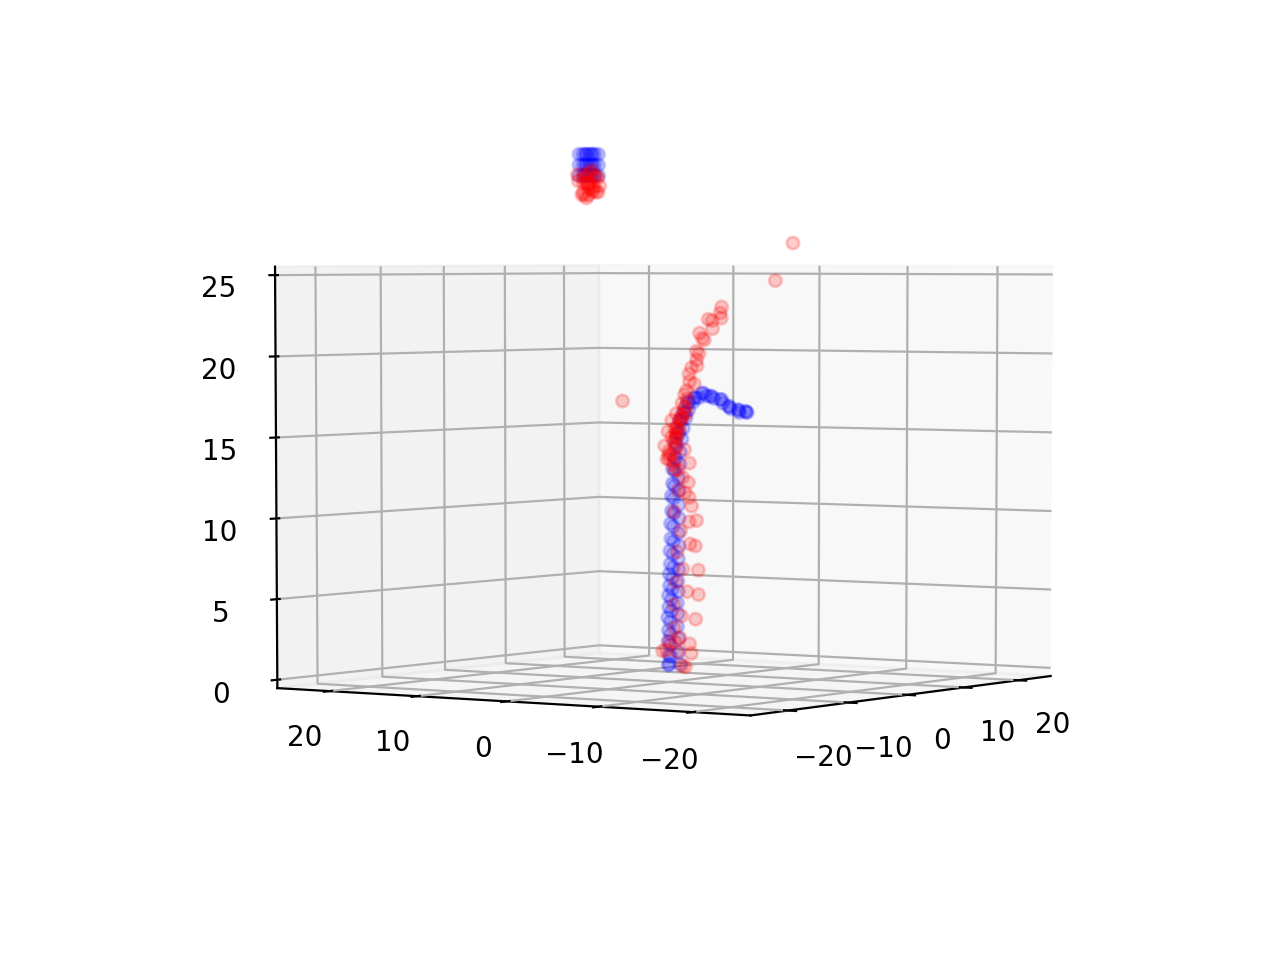

In [748]:
r = 2
rollout = val_rollouts[r]
pred = pred_rollout(rollout, model)
n = 2000
# plot_obs(rollout[:n,3:].flatten(), pred[:n].flatten())
pred
i = 10
plot_obs(rollout[i,3:], pred[i])

<IPython.core.display.Javascript object>


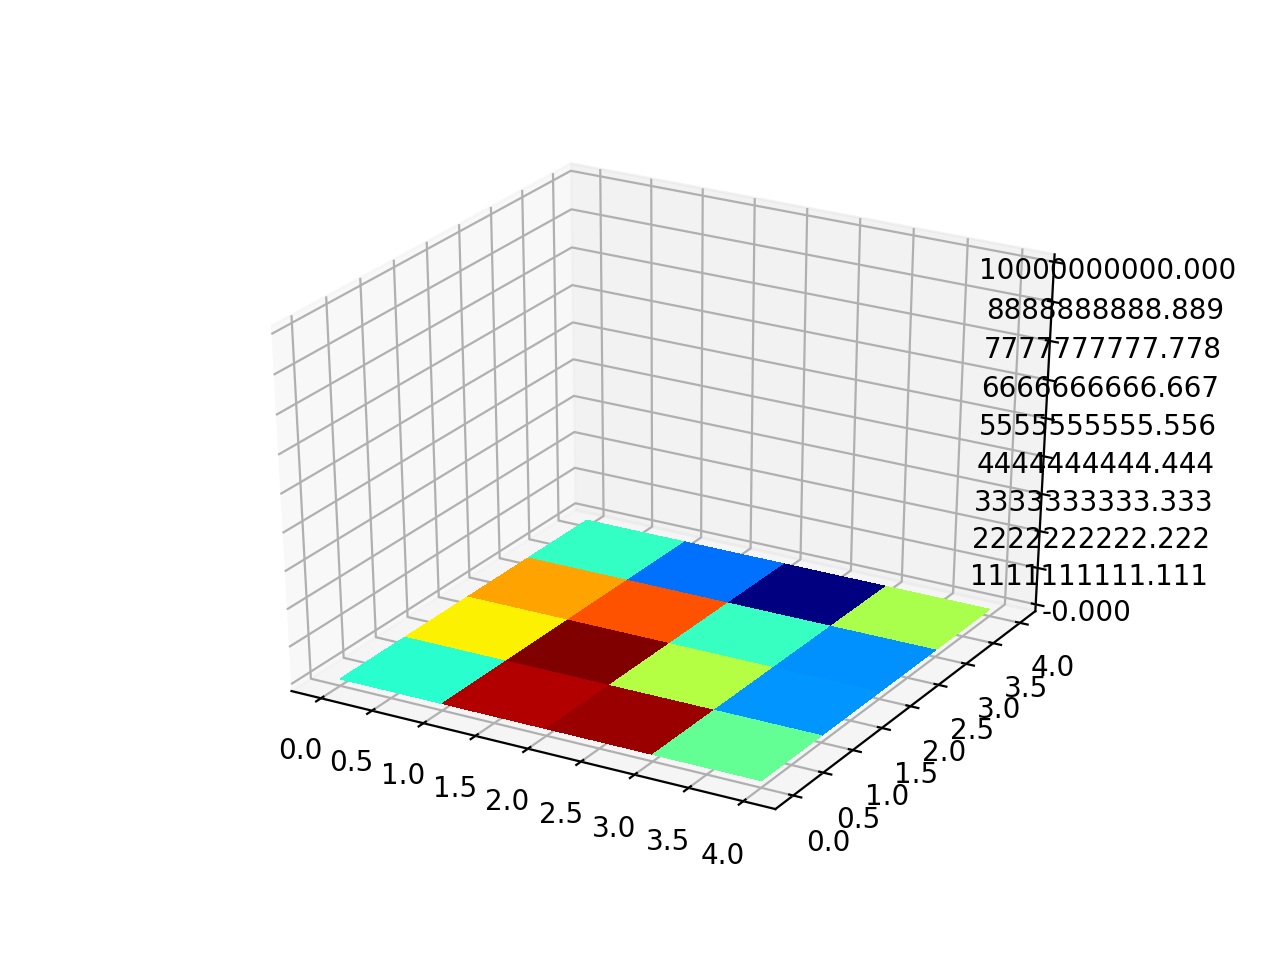

In [262]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FixedLocator, FormatStrFormatter
import matplotlib, time

class plot3dClass( object ):

    def __init__( self, systemSideLength, lowerCutoffLength ):
        self.systemSideLength = systemSideLength
        self.lowerCutoffLength = lowerCutoffLength
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot( 111, projection='3d' )
        self.ax.set_zlim3d( -10e-9, 10e9 )

        rng = np.arange( 0, self.systemSideLength, self.lowerCutoffLength )
        self.X, self.Y = np.meshgrid(rng,rng)

        self.ax.w_zaxis.set_major_locator( LinearLocator( 10 ) )
        self.ax.w_zaxis.set_major_formatter( FormatStrFormatter( '%.03f' ) )

        heightR = np.zeros( self.X.shape )
        self.surf = self.ax.plot_surface( 
            self.X, self.Y, heightR, rstride=1, cstride=1, 
            cmap=cm.jet, linewidth=0, antialiased=False )
        # plt.draw() maybe you want to see this frame?

    def drawNow( self, heightR ):
        self.surf.remove()
        self.surf = self.ax.plot_surface( 
            self.X, self.Y, heightR, rstride=1, cstride=1, 
            cmap=cm.jet, linewidth=0, antialiased=False )
        plt.draw()                      # redraw the canvas
        time.sleep(1)

matplotlib.interactive(True)

p = plot3dClass(5,1)
for i in range(2):
    p.drawNow(np.random.random(p.X.shape))

In [263]:
rollout.flatten().shape

(29970,)